# Fitting non-polynomial functions

(Note: This notebook uses the package `sdeint`, which can be installed using `pip install sdeint`.)

By default, `pyddsde` fits polynomial functions for drift and diffusions. However, if the expected functional form is not a polynomial, `pyddsde` provides the option to fit using a custom library of candidate functions.

In [1]:
import pyddsde
import sdeint
import numpy as np

Let us generate some simulated time-series data with specified drift and diffusion, and try to recover the drift and diffusion back from the time-series. The functions we use are just for demonstration, and may not have any ecological or physical significance.

In [2]:
def f(x, t): return np.cos(x) + 0.5 * np.sin(2 * x)
def g(x, t): return 1

# Simulate and plot data
t_inc = 0.01
timepoints = 1e5
tspan = np.arange(0, t_inc * timepoints, step=t_inc)
data = sdeint.itoint(f=f, G=g, y0=0.1, tspan=tspan)

| M range              : (-7.171, 6.231)|
| M mean               :      1.123     |
| |M| range            :  (0.0, 7.171)  |
| |M| mean             :      1.772     |
| Autocorr time (M)    :       787      |
| (Dt, dt)             :     (1, 1)     |



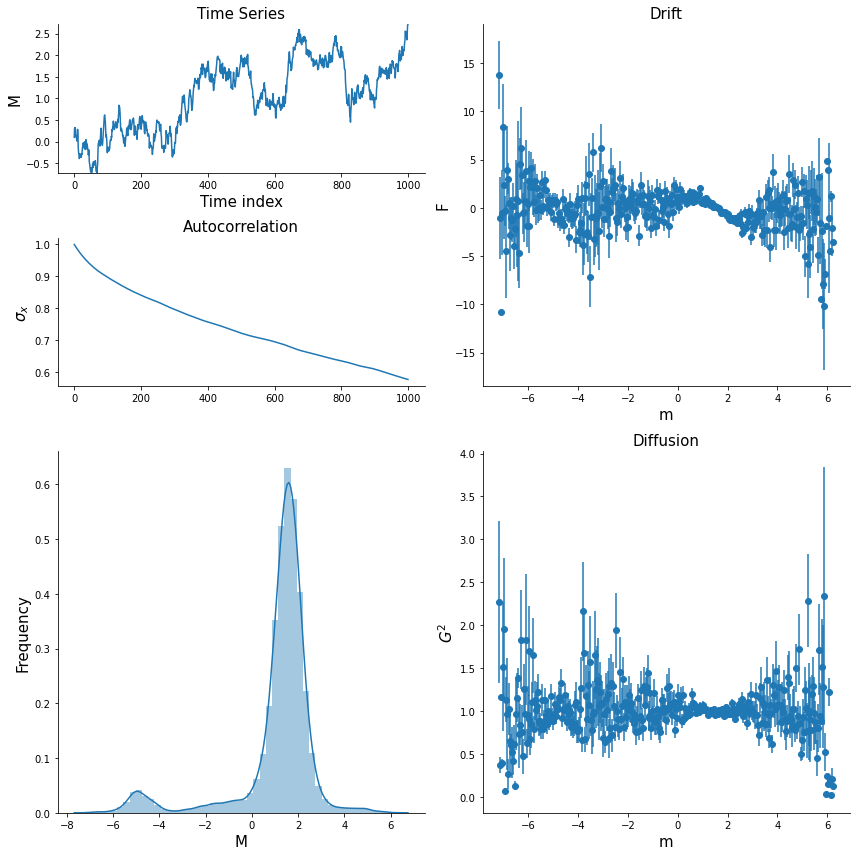

In [3]:
ddsde = pyddsde.Characterize([data], tspan)

The custom library can be defined as a list of functions, as follows. In this case, our library consists of sinusoids of 3 different frequencies, and the constant function. The functions you choose to include in the library will depend on the specific problem.

In [4]:
library = [
        lambda x: np.ones_like(x),  # Each function in the library, when called with an np.array, should return an array of the same shape.
        lambda x: np.sin(x),
        lambda x: np.cos(x),
        lambda x: np.sin(2 * x),
        lambda x: np.cos(2 * x),
        lambda x: np.sin(3 * x),
        lambda x: np.cos(3 * x),
    ]

While calling `ddsde.fit`, the library can now be passed as a parameter. The output will now just be a list of coefficients, corresponding to each function in the library. Two arrays are returned, corresponding to the coefficient values and their standard errors respectively.

In [5]:
F = ddsde.fit('F', library=library, tune=False, threshold=0.2)
F

(array([0.        , 0.        , 0.84857225, 0.6083971 , 0.        ,
        0.        , 0.        ]),
 array([0.06344198, 0.08477649, 0.09261533, 0.08872613, 0.08848754,
        0.06865799, 0.06742452]))

Here, the second and third coefficients, corresponding to the $\cos x$ and $\sin 2x$ terms of the library, are non-zero: this matches with our original model.

In [6]:
G = ddsde.fit('G', library=library, tune=False, threshold=0.2)
G

(array([1.00423849, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ]),
 array([0.00898072, 0.01200079, 0.01311044, 0.0125599 , 0.01252612,
        0.00971909, 0.00954448]))

*Note:* Although in this case we used the same library for both drift and diffusion, this need not be the case in general: if required, we can use different libraries while fitting different functions.